<a href="https://colab.research.google.com/github/tangshuting/daytoy/blob/master/EMW_NN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pickle
import numpy as np
from scipy import integrate
import os,random
#os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["THEANO_FLAGS"]  = "device=cuda,floatX=float32"
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras

In [15]:
from google.colab import drive
drive.mount('/content/drive')
f = open(r'/content/drive/My Drive/EMW/2016.04C.multisnr.pkl','rb') 
dataDict = pickle.load(f,encoding='bytes')
print(type(dataDict))   # dict
print(len(dataDict))  #220=11（类别）×20（20个snr）

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'dict'>
220


In [16]:
data = []
labels = []
for d in dataDict:
   signals=dataDict[d]
   for s in signals:
     data.append(np.array(s))
     labels.append(d)
data = np.array(data)
labels = np.array(labels)
print(data.shape) 
print(labels.shape)
print(labels)


(162060, 2, 128)
(162060, 2)
[[b'QPSK' b'2']
 [b'QPSK' b'2']
 [b'QPSK' b'2']
 ...
 [b'WBFM' b'12']
 [b'WBFM' b'12']
 [b'WBFM' b'12']]


In [0]:
indices = random.sample(range(0,162060),162060)
xTrain = []
yTrain = []
iTrain = []
for i in range(0,81030):
  xTrain.append(data[indices[i]])
  yTrain.append(labels[indices[i]])
  iTrain.append(indices[i])
xTrain = np.array(xTrain)
yTrain = np.array(yTrain)
iTrain = np.array(iTrain)

In [0]:
xTest = []
yTest = []
iTest = []
for i in range(81030, 162060):
  xTest.append(data[indices[i]])
  yTest.append(labels[indices[i]])
  iTest.append(indices[i])
xTest = np.array(xTest)
yTest = np.array(yTest)
iTest = np.array(iTest)  

In [19]:
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
print(iTrain.shape)
print(iTest.shape)

(81030, 2, 128)
(81030, 2)
(81030, 2, 128)
(81030, 2)
(81030,)
(81030,)


In [20]:
# one-hot enconding
#Sklearn’s one hot encoder doesn’t actually know how to convert categories to numbers, 
#it only knows how to convert numbers to binary. We have to use the labelencoder first.
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
le = LabelEncoder()

yTrain_SNR = yTrain[:,1]
yTest_SNR = yTest[:,1]
print(yTrain_SNR.shape)
print(yTest_SNR.shape)
print(yTrain_SNR)
print(yTest_SNR)
print(yTest[81028])  #随便找一个例子看一下输出结果是否正确
print(yTest_SNR[81028])

yTrain_le = le.fit_transform(yTrain[:, 0])
yTest_le = le.fit_transform(yTest[:, 0])
print(yTrain_le.shape)
print(yTest_le.shape)
print(yTrain_le[81028])
print(yTest_le[81028])   #label编码后

yTrain_le = yTrain_le.reshape(len(yTrain_le), 1)
yTest_le = yTest_le.reshape(len(yTest_le), 1)

enc = OneHotEncoder(categories = 'auto',sparse = False )  #将分类特征的每个元素转化为一个可以用来计算的值
yTrain_ohe = enc.fit_transform(yTrain_le)  # 如果不加 toarray() 的话，输出的是稀疏的存储格式，即索引加值的形式，也可以通过参数指定 sparse = False 来达到同样的效果
yTest_ohe = enc.fit_transform(yTest_le)
print(yTrain_ohe[81028])  #onehot编码后
print(yTest_ohe[81028])  #onehot编码后

(81030,)
(81030,)
[b'10' b'14' b'-2' ... b'-10' b'-14' b'10']
[b'0' b'2' b'2' ... b'-16' b'-10' b'-2']
[b'8PSK' b'-10']
b'-10'
(81030,)
(81030,)
5
0
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [21]:
"""# **Fully Connected Neural Network**
## Load Data (Reformated)
"""
import numpy as np

# Reformated xTrain
# print(xTrain.shape[0])
xTrain_reforamted = []
for i in range(0,xTrain.shape[0]):
  xTrain_reforamted.append(np.concatenate((xTrain[i,0,:] , xTrain[i,1,:]), axis=0))  
xTrain_reforamted = np.array(xTrain_reforamted) 
print("Reformated Train size")
print(xTrain_reforamted.shape)

# Reformated xTest
# print(xTest.shape[0])
xTest_reforamted = []
for i in range(0,xTest.shape[0]):
  xTest_reforamted.append(np.concatenate((xTest[i,0,:] , xTest[i,1,:]), axis=0)) 
xTest_reforamted = np.array(xTest_reforamted)  
print("Reformated Test size")
print(xTest_reforamted.shape)
  
## 1 sample Test
# sample = np.concatenate((xTrain[0,0,:] , xTrain[0,1,:]), axis=0)
# print("Sample size")
# print(sample.size)

from sklearn.model_selection import train_test_split

## split 5% as validation set from xTrain and yTrain Datasets
#   using scklearn function for splitting train/test data

# xTrain_reforamted, xValid, yTrain_ohe, yValid = train_test_split(xTrain_reforamted, yTrain_ohe, test_size=0.05, shuffle= True)

print("xTrain Size")
print(xTrain_reforamted.shape)

print("yTrain Size")
print(yTrain_ohe.shape)


print("yTest Size")
print(yTest_ohe.shape)
"""## Define, Compile, Train, Evaluate  Model  --  (Single Configuration for NN)"""

Reformated Train size
(81030, 256)
Reformated Test size
(81030, 256)
xTrain Size
(81030, 256)
yTrain Size
(81030, 11)
yTest Size
(81030, 11)


'## Define, Compile, Train, Evaluate  Model  --  (Single Configuration for NN)'

In [0]:
# 全连接网络
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.callbacks import ModelCheckpoint

In [0]:
# create model
model = Sequential()
model.add(Dense(512, input_dim=256, activation='relu'))
# model.add(Dense(256,input_dim=256,activation='relu'))
# model.add(Dense(256,  activation='relu'))
model.add(Dense(135, activation='relu'))
#soft max as O/P activation -> multiclass classification 
model.add(Dense(11, activation='softmax'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
# checkpoint
filepath="/content/drive/My Drive/EMW/best.hdf5weights.best.hdf5"  #保存到挂载的谷歌云盘
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [26]:
#arguments to specify:
# 1. nepochs: a fixed number of iterations through the dataset 
# 2. batch_size: the number of instances that are evaluated before a weight update in the network is performed

# Fit the model
model.fit(xTrain_reforamted, yTrain_ohe, validation_split=0.1,shuffle=True, epochs=50, batch_size=512, callbacks=callbacks_list, verbose=0)
# model.fit(xTrain_reforamted, yTrain_ohe, shuffle=True, epochs=1, batch_size=256, callbacks=callbacks_list, verbose=0)

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


In [27]:
# Model Summary
print("Model Summary")
print(model.summary())

Model Summary
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 135)               69255     
_________________________________________________________________
dense_3 (Dense)              (None, 11)                1496      
Total params: 202,335
Trainable params: 202,335
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
#evaluating our model on the taining set can help us to determine 
# how much the model overfitt/ underfits the data

print("Testing on test set")
score = model.evaluate(xTest_reforamted, yTest_ohe)
print("\n%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Testing on test set
81030/81030 [==============================] - 3s 34us/step

accuracy: 59.63%


In [0]:
# model.save_weights(filepath) #只保存了模型的权重而没有结构，直接loda模型时报错cannt create groupread in read only mode  
model.save(filepath) #存了模型的权重和结构

In [31]:
print(yTest_SNR)
yTest_SNR_str = []
for i in yTest_SNR:
  yTest_SNR_str.append(str(i).split('\'')[1])
print(yTest_SNR_str)
# print(bool(SNR[3]==yTest_SNR_str[0]))


[b'0' b'2' b'2' ... b'-16' b'-10' b'-2']
['0', '2', '2', '-12', '18', '-14', '-6', '-10', '8', '6', '16', '-16', '4', '16', '12', '-16', '-12', '-10', '12', '16', '-4', '-8', '-12', '18', '-10', '16', '-12', '-18', '-6', '-14', '-12', '-16', '8', '-8', '-16', '-16', '2', '-2', '4', '-10', '10', '-10', '-4', '-12', '-20', '-16', '-12', '-18', '-10', '8', '-2', '-12', '10', '12', '-12', '12', '8', '14', '12', '18', '14', '8', '-18', '-20', '-6', '16', '-14', '-12', '2', '6', '4', '4', '-8', '4', '-20', '-18', '-4', '10', '4', '6', '-8', '-20', '-18', '8', '0', '6', '-18', '6', '-2', '6', '-14', '-20', '-16', '-6', '-10', '-8', '2', '-20', '-8', '6', '6', '10', '8', '6', '12', '12', '-4', '6', '4', '12', '-14', '18', '-18', '4', '18', '10', '18', '-10', '8', '4', '4', '16', '-6', '12', '-12', '4', '8', '-20', '4', '-20', '-20', '2', '-6', '-4', '-12', '-14', '12', '16', '-8', '0', '-10', '-4', '0', '2', '18', '14', '8', '4', '-8', '10', '-16', '18', '4', '-8', '14', '-4', '16', '8', '-6',

Accuracy for SNR =  -20  is  14.243614673614502
Accuracy for SNR =  -18  is  13.63181620836258
Accuracy for SNR =  -16  is  13.308550417423248
Accuracy for SNR =  -14  is  15.036097168922424
Accuracy for SNR =  -12  is  16.5608212351799
Accuracy for SNR =  -10  is  22.33033925294876
Accuracy for SNR =  -8  is  33.36568772792816
Accuracy for SNR =  -6  is  48.31932783126831
Accuracy for SNR =  -4  is  64.57366347312927
Accuracy for SNR =  -2  is  77.26382613182068
Accuracy for SNR =  0  is  83.01464915275574
Accuracy for SNR =  2  is  85.43521165847778
Accuracy for SNR =  4  is  86.61710023880005
Accuracy for SNR =  6  is  86.65515780448914
Accuracy for SNR =  8  is  84.93692874908447
Accuracy for SNR =  10  is  91.64779782295227
Accuracy for SNR =  12  is  91.74356460571289
Accuracy for SNR =  14  is  84.3565821647644
Accuracy for SNR =  16  is  86.27451062202454
Accuracy for SNR =  18  is  92.9710865020752


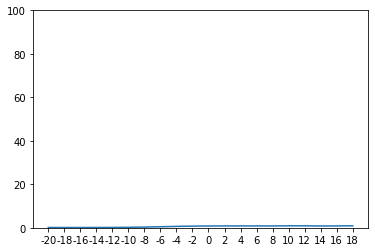

In [32]:
import numpy as np
SNR = np.unique(labels[:,1])
SNR = list(map(int, SNR))
SNR.sort()
SNR = list(map(str, SNR))
# print(SNR)

# print(yTest_SNR)
yTest_SNR_str = []
for i in yTest_SNR:
  yTest_SNR_str.append(str(i).split('\'')[1])
# print(yTest_SNR_str)
# print(bool(SNR[3]==yTest_SNR_str[0]))

"""# Accuracy Plot"""

from keras.models import load_model
# saved_model = load_model('/content/drive/My Drive/EMW/best.hdf5weights.best.hdf5')
saved_model = load_model(filepath)

accuracy = []
for s in SNR:
    SNR_index = []
    SNR_Y = []
    SNR_X = []
    for index in range(0,len(yTest_SNR_str)):
        if s == yTest_SNR_str[index]:
            SNR_index.append(index)
            SNR_Y.append(yTest_ohe[index])
            SNR_X.append(xTest_reforamted[index])

    y = np.array(SNR_Y)
    # print(y)
    x = np.array(SNR_X)
    result = model.evaluate(x, y, verbose=2)
    print('Accuracy for SNR = ', s, ' is ', result[1] * 100)
    accuracy.append(result[1])


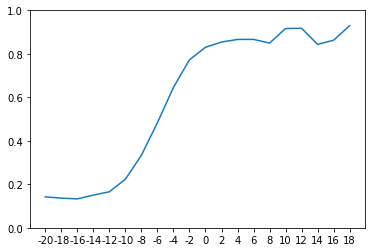

In [34]:
import matplotlib.pyplot as plt
plt.ylim(0, 1)
plt.plot(SNR, accuracy)
plt.show()

In [0]:
"""# Accuracy Plot"""
yTest_SNR_str = []
for i in yTest_SNR:
  yTest_SNR_str.append(str(i).split('\'')[1])

from keras.models import load_model
# saved_model = load_model('/content/drive/My Drive/EMW/best.hdf5weights.best.hdf5')  
saved_model = load_model(filepath)

SNR = np.unique(labels[:,1])
SNR = list(map(int, SNR))
SNR.sort()
SNR = list(map(str, SNR))
print(SNR)

In [0]:
accuracy = []

for s in SNR:
    SNR_index = []
    SNR_Y = []
    SNR_X = []
    for index in range(0,len(yTest_SNR_str)):
        if s == yTest_SNR_str[index]:
            SNR_index.append(index)
            SNR_Y.append(yTest_ohe[index])
            SNR_X.append(xTest_reforamted[index])

    y = np.array(SNR_Y)
    # print(y)
    x = np.array(SNR_X)
    result = model.evaluate(x, y, verbose=2)
    print('Accuracy for SNR = ', s, ' is ', result[1] * 100)
    accuracy.append(result[1])
  
print(accuracy)

In [0]:


# for s in SNR:
#   # y = []
#   # x = []
#   # M = np.where(yTest_SNR_str == s)
#   # print(len(M))
#   # for i in M:
#   #   print(i)
#   #   print('----')

#   # y.append(yTest_ohe[m_index[20]])
#   # x.append(xTest_reforamted[m_index[20]])
#   # print(m_index[0])
#   y = np.array(SNR__20_Y)
#   # print(y)
#   x = np.array(SNR__20_X)
#   # print(x)
#   result = model.evaluate(x, y,verbose=1)
#   print('Accuracy for SNR = ', s, ' is ', result[1]*100)
#   accuracy.append(result[1])

In [0]:
# m_index = []
# print((len(yTest_SNR_str)-1))
# for s in SNR:
#   for index in range(0,int(len(yTest_SNR_str)-1)):
#     if s == yTest_SNR_str[index]:
#       if (index%2000==0):
#         # print(s)
#         print(yTest_SNR_str[index])
#         print(index)
#         print('------------------------')
#       m_index.append(index)
# print(len(m_index))
# print(m_index)


In [0]:
# print(bool(str(yTest_SNR[0]).split('\'')[1]==SNR[3]))
# print(yTest_SNR_str[0])

In [0]:
import matplotlib.pyplot as plt
plt.ylim(0, 1.0)
plt.plot(SNR, accuracy)

In [0]:
# 单个SNR https://paste.ubuntu.com/p/SNC3vvz2Mv/
# 多个SNR https://paste.ubuntu.com/p/ZppStMDmvt/